In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [10]:
# Calculate ranks for each metric within each dataset-model combination
def calculate_detailed_ranks(df):
    ranks = []

    for dataset in df["dataset"].unique():
        for model in df["model"].unique():
            subset = df[(df["dataset"] == dataset) & (df["model"] == model)]

            # Calculate ranks for each metric
            validity_ranks = subset["Validity"].rank(
                ascending=False
            )  # higher is better
            plausibility_ranks = subset["Log Density"].rank(
                ascending=False
            )  # higher is better
            proximity_ranks = subset["L2"].rank(ascending=True)  # lower is better

            # Calculate average rank
            avg_rank = (validity_ranks + plausibility_ranks + proximity_ranks) / 3

            for method, v_rank, s_rank, p_rank, a_rank in zip(
                subset["method"],
                validity_ranks,
                plausibility_ranks,
                proximity_ranks,
                avg_rank,
            ):
                ranks.append(
                    {
                        "dataset": dataset,
                        "model": model,
                        "method": method,
                        "validity_rank": v_rank,
                        "plausibility_rank": s_rank,
                        "proximity_rank": p_rank,
                        "avg_rank": a_rank,
                    }
                )

    return pd.DataFrame(ranks)


def custom_sort(item):
    # Check if item starts with 'our'
    if "our" in item.lower():
        # Return a tuple with 0 to ensure it comes first, followed by the original string
        return (0, item)
    # For all other items, return tuple with 1 to place them after
    return (1, item)


def plot(dataframe: pd.DataFrame):
    # Calculate ranks
    ranks_df = calculate_detailed_ranks(dataframe)

    # Calculate means and standard deviations
    means = pd.DataFrame(
        {
            "Validity": ranks_df.groupby("method")["validity_rank"].mean(),
            "Plausibility": ranks_df.groupby("method")["plausibility_rank"].mean(),
            "Proximity": ranks_df.groupby("method")["proximity_rank"].mean(),
        }
    )

    stds = pd.DataFrame(
        {
            "Validity": ranks_df.groupby("method")["validity_rank"].std(),
            "Plausibility": ranks_df.groupby("method")["plausibility_rank"].std(),
            "Proximity": ranks_df.groupby("method")["proximity_rank"].std(),
        }
    )

    # Set style parameters
    plt.style.use("seaborn-v0_8-darkgrid")
    plt.rcParams["figure.facecolor"] = "white"
    plt.rcParams["axes.facecolor"] = "white"

    # Define colors (modern, professional palette)
    colors = ["#2ecc71", "#3498db", "#9b59b6", "#e74c3c", "#f1c40f"]
    grid_color = "#ecf0f1"

    # Create figure
    fig, ax = plt.subplots(figsize=(5, 4), dpi=300)

    # Set positions for bars
    metrics = ["Validity", "Plausibility", "Proximity"]

    methods = sorted_items = sorted(means.index.tolist(), key=custom_sort)
    x = np.arange(len(metrics))
    width = 0.20

    # Create bars for each method with error bars
    for i, method in enumerate(methods):
        offset = (i - len(methods) / 2 + 0.5) * width

        # Extract means and stds for this method
        method_means = means.loc[method]
        method_stds = stds.loc[method]

        # Create bars with error bars
        bars = ax.bar(
            x + offset,
            method_means,
            width=width,
            label=method,
            color=colors[i],
            alpha=0.8,
            edgecolor="none",
        )

        # Add error bars
        ax.errorbar(
            x + offset,
            method_means,
            yerr=method_stds,
            fmt="none",
            color="#2c3e50",  # Dark color for error bars
            capsize=3,
            capthick=1,
            elinewidth=1,
            alpha=0.5,
        )

        # Add value labels on top of bars
        # for j, bar in enumerate(bars):
        #     height = bar.get_height()
        #     ax.text(bar.get_x() + bar.get_width()/2., height,
        #             f'{height:.2f}±{method_stds[j]:.2f}',
        #             ha='center', va='bottom',
        #             fontsize=8)

    # Customize plot
    # ax.set_xlabel("Metrics", fontsize=12, fontfamily="sans-serif")
    ax.set_ylabel("Average Rank", fontsize=12, fontfamily="sans-serif")
    # ax.set_title('Average Ranks by Metric with Standard Deviation\n(lower is better)',
    #              fontsize=14, fontfamily='sans-serif')

    # Set ticks
    max_rank = round(
        ranks_df[["validity_rank", "plausibility_rank", "proximity_rank"]].max().max()
    )

    ax.set_xticks(x)
    ax.set_xticklabels(metrics, fontsize=12, fontfamily="sans-serif")
    ax.set_yticks(range(0, max_rank + 1))
    ax.set_ylim(0.5, max_rank + 0.25)

    # Add grid with better styling
    ax.grid(True, axis="y", linestyle="--", alpha=0.3, color=grid_color)
    ax.set_axisbelow(True)  # Put grid below bars

    # Remove top and right spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Lighten the remaining spines
    ax.spines["left"].set_color("#bdc3c7")
    ax.spines["bottom"].set_color("#bdc3c7")

    # Enhance legend
    box = ax.get_position()
    # ax.set_position([box.x0, box.y0 + box.height * 0.2, box.width, box.height * 0.8])

    legend = ax.legend(
        # title='Methods',
        bbox_to_anchor=(0.5, -0.20),
        ncol=len(methods),
        loc="upper center",
        frameon=True,
        fancybox=True,
        shadow=False,
        fontsize=10,
    )
    # legend.get_title().set_fontsize(12)

    # Add horizontal lines for better readability
    for y in ax.get_yticks():
        ax.axhline(y=y, color="#ecf0f1", linestyle="-", linewidth=0.5, alpha=0.5)

    # Adjust layout
    fig.tight_layout()
    return fig, ax

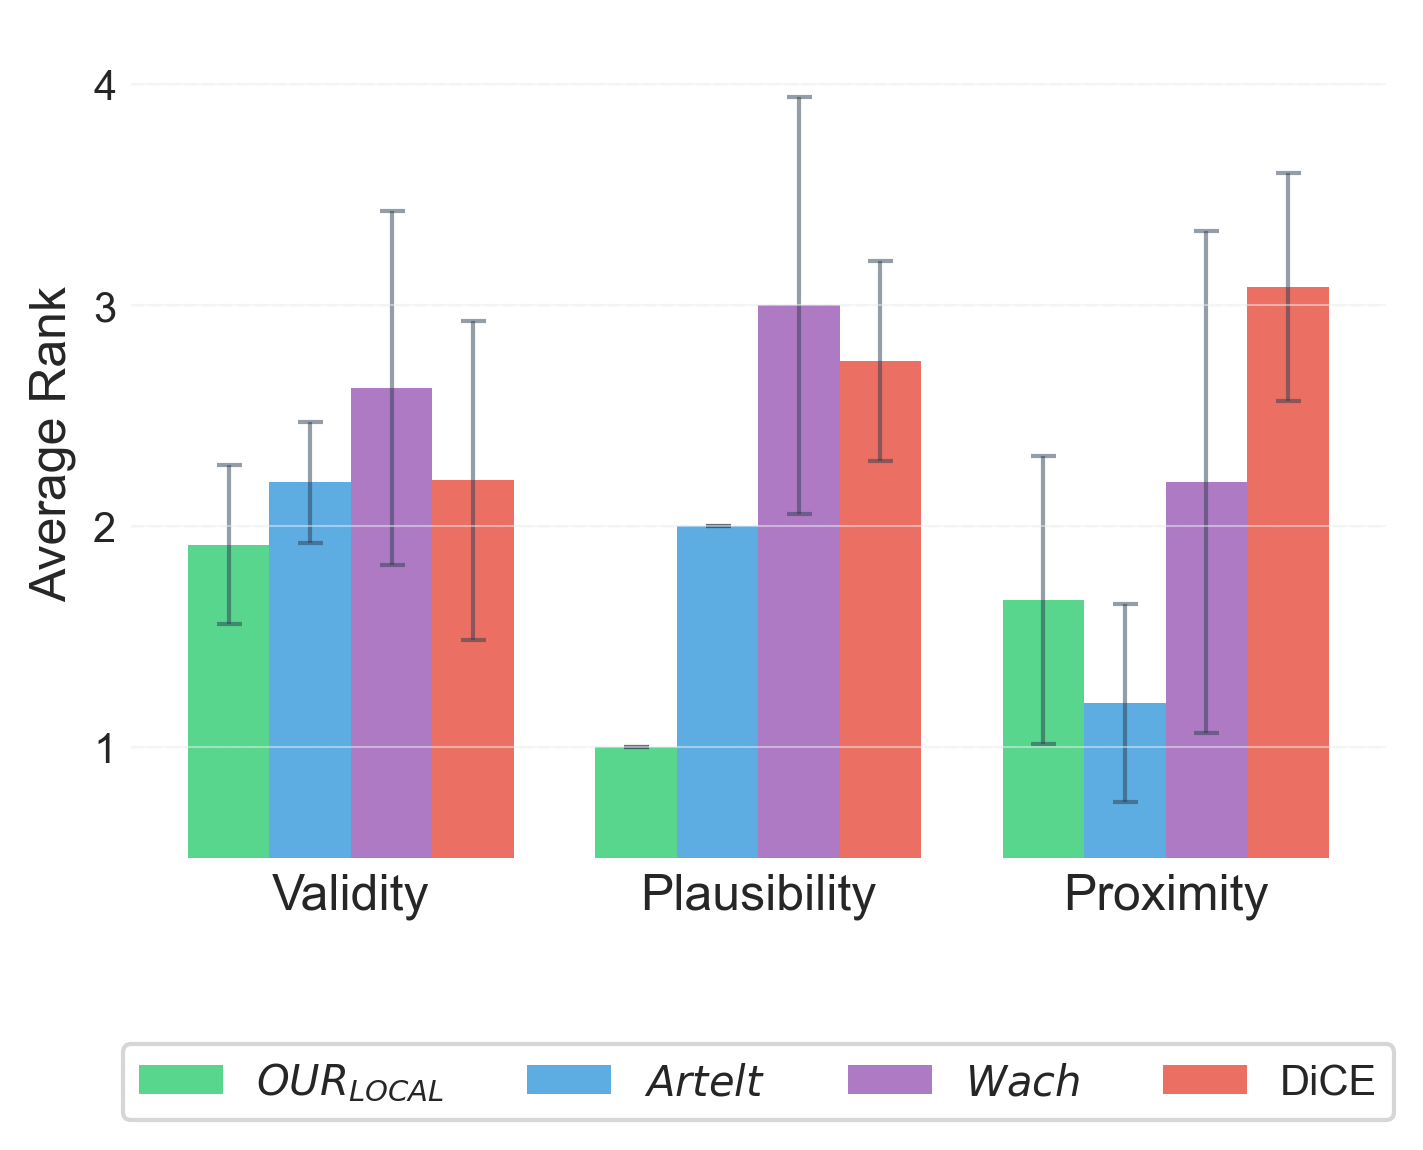

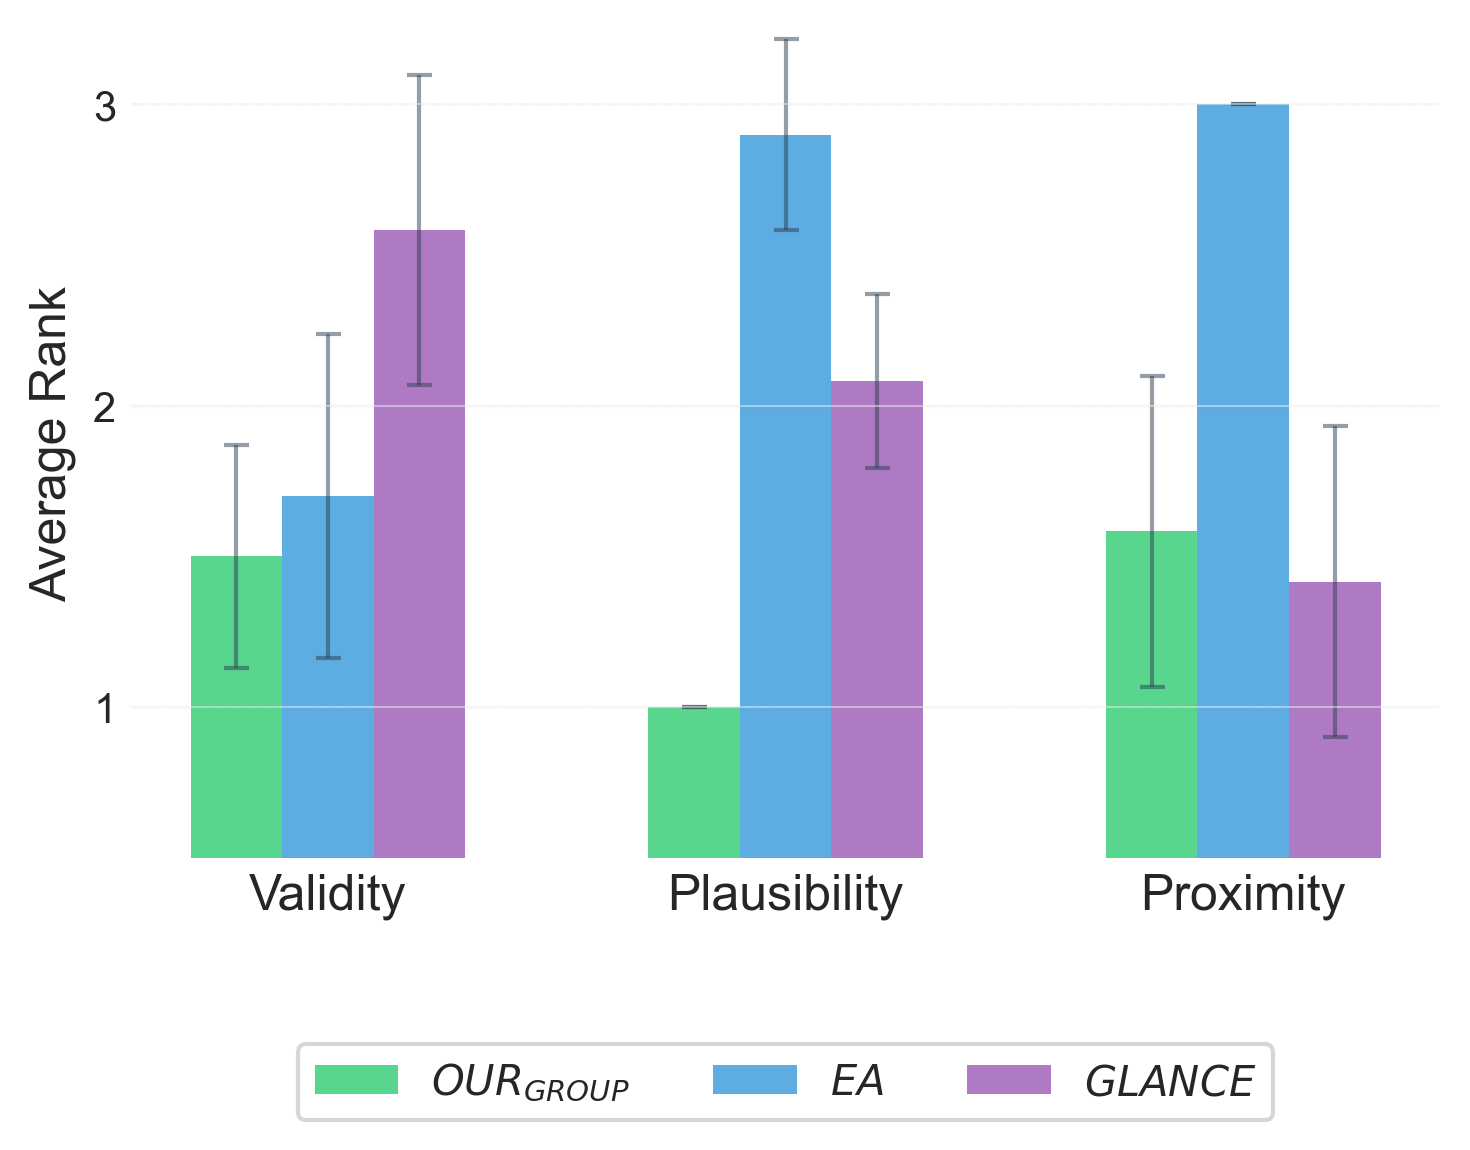

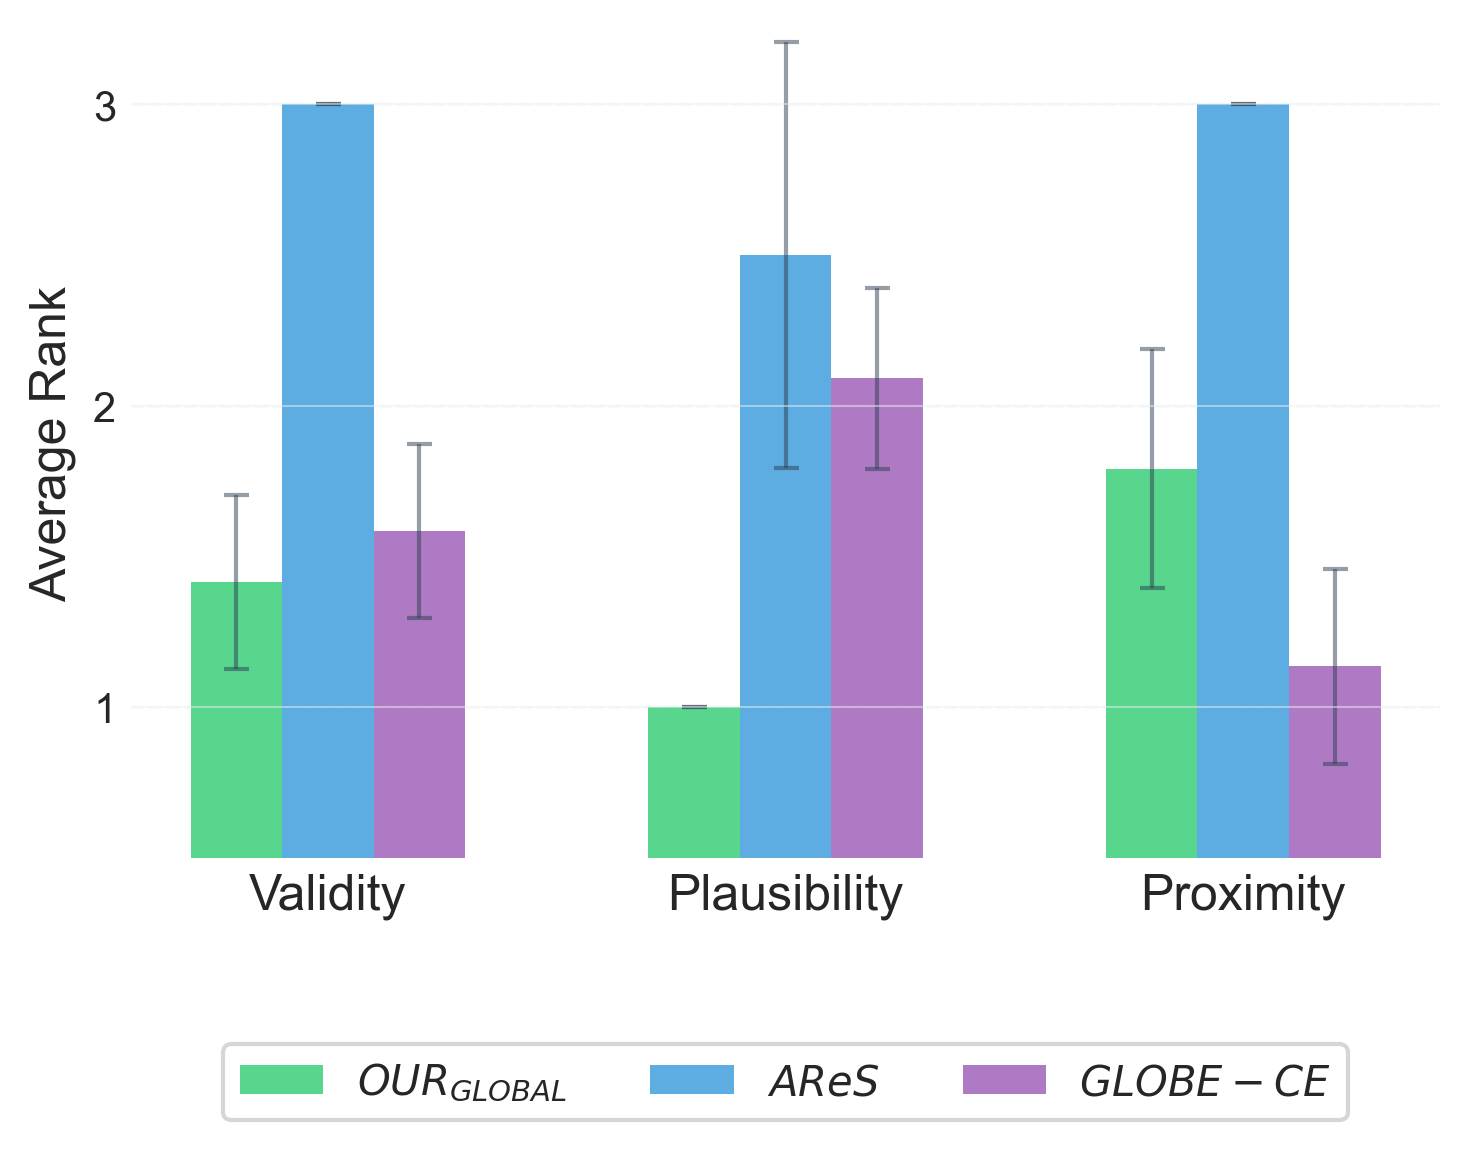

In [12]:
for cf_type in ["LOCAL", "GROUP", "GLOBAL"]:
    df = pd.read_csv(f"results_{cf_type}_grouped.csv")

    fig, ax = plot(df)
    fig.savefig(f"mock_results/plot_rank_{cf_type}.pdf")